# Comparação de Modelos (Exploration)

Notebook para comparar diferentes classificadores no pipeline de Predictive RCA, mantendo boas práticas: divisão estratificada, pré-processamento único, random seed fixo e avaliação consistente em validação e teste.


**Notas de boas práticas**

- Manter o mesmo pré-processamento e splits para todos os modelos (evita vazamento e garante comparabilidade).
- Fixar `random_state` para reprodutibilidade.
- Avaliar em validação e teste com a mesma métrica principal (AUC-ROC) e threshold padrão 0.5 para classificação.
- Inspecionar relatórios por classe para checar precisão/recall e usar gráficos (ROC, matriz de confusão) para entender a resposta de cada algoritmo.


In [5]:
import sys
import os

sys.path.append(os.path.abspath(".."))

In [6]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
)

from src.config.settings import CONFIG
from src.preprocessing.build_features import build_case_features
from src.preprocessing.split import stratified_case_split
from src.preprocessing.preprocess import (
    build_preprocessor,
    fit_preprocessor_and_transform,
)
from src.models.lightgbm_model import LightGBMModel
from src.models.random_forest import RandomForestModel
from src.models.logistic_regression import LogisticRegressionModel
from src.models.xgboost_model import XGBoostModel

pd.options.display.float_format = lambda v: f"{v:.4f}"
plt.style.use("ggplot")

In [7]:
# Carregar e preparar dataset em nível de caso
log_path = Path("../data/raw/csv/event_log_sintetico_2000_cases.csv")
sla_hours = CONFIG.SLA_HOURS

df_events = pd.read_csv(log_path)
if "timestamp" in df_events.columns:
    df_events["timestamp"] = pd.to_datetime(df_events["timestamp"])

df_cases = build_case_features(df_events, sla_hours=sla_hours)
df_cases.head()

,case_id,throughput_hours,num_events,num_unique_activities,rework_count,start_activity,end_activity,start_resource,mean_cost,sla_violated
0,1,46.3033,4,4,0,Receber Pedido,Finalizar,Ana,87.5350,1
1,2,69.1386,5,5,0,Receber Pedido,Finalizar,João,72.2880,1
2,3,8.9614,6,5,1,Receber Pedido,Finalizar,Pedro,79.4467,0
3,4,41.3628,7,5,2,Receber Pedido,Finalizar,João,75.1771,1
4,5,26.1333,6,6,0,Receber Pedido,Finalizar,Marina,79.8367,1


In [8]:
# Split estratificado e pré-processamento único para todos os modelos
splits, numeric_features, categorical_features = stratified_case_split(
    df_cases,
    target_col="sla_violated",
    id_col="case_id",
    random_state=CONFIG.RANDOM_STATE,
)

preprocessor = build_preprocessor(numeric_features, categorical_features)
artifacts, X_train_pre, X_val_pre, X_test_pre = fit_preprocessor_and_transform(
    preprocessor, splits, numeric_features, categorical_features
)

y_train = splits.y_train.to_numpy()
y_val = splits.y_val.to_numpy()
y_test = splits.y_test.to_numpy()

numeric_features, categorical_features

(['throughput_hours',
  'num_events',
  'num_unique_activities',
  'rework_count',
  'mean_cost'],
 ['start_activity', 'end_activity', 'start_resource'])

In [9]:
from typing import Any, Dict, List, Tuple


def summarize_split(y_true, y_proba, threshold: float = 0.5):
    y_pred = (y_proba >= threshold).astype(int)
    report_dict = classification_report(
        y_true, y_pred, output_dict=True, zero_division=0
    )
    return {
        "auc": roc_auc_score(y_true, y_proba),
        "precision": report_dict["1"]["precision"],
        "recall": report_dict["1"]["recall"],
        "f1": report_dict["1"]["f1-score"],
        "support": int(report_dict["1"]["support"]),
        "report_text": classification_report(y_true, y_pred, zero_division=0),
        "confusion": confusion_matrix(y_true, y_pred),
        "pred": y_pred,
        "proba": y_proba,
    }


def train_and_eval(
    model_class, params: Dict[str, Any] | None = None, name: str | None = None
):
    params = params or {}
    model = model_class(**params)
    model.train(X_train_pre, y_train)

    val = summarize_split(y_val, model.predict_proba(X_val_pre)[:, 1])
    test = summarize_split(y_test, model.predict_proba(X_test_pre)[:, 1])

    return {
        "model": name or model_class.__name__,
        "val_auc": val["auc"],
        "test_auc": test["auc"],
        "val_precision": val["precision"],
        "test_precision": test["precision"],
        "val_recall": val["recall"],
        "test_recall": test["recall"],
        "val_f1": val["f1"],
        "test_f1": test["f1"],
        "val_report": val["report_text"],
        "test_report": test["report_text"],
        "val_confusion": val["confusion"],
        "test_confusion": test["confusion"],
        "val_pred": val["pred"],
        "test_pred": test["pred"],
        "val_proba": val["proba"],
        "test_proba": test["proba"],
    }


experiments: List[Tuple[str, Any, Dict[str, Any]]] = [
    (
        "LightGBM",
        LightGBMModel,
        {
            "objective": "binary",
            "n_estimators": 300,
            "learning_rate": 0.05,
            "num_leaves": 64,
            "max_depth": -1,
            "feature_fraction": 0.8,
            "random_state": CONFIG.RANDOM_STATE,
            "n_jobs": -1,
        },
    ),
    (
        "RandomForest",
        RandomForestModel,
        {
            "n_estimators": 400,
            "max_depth": 12,
            "min_samples_leaf": 2,
            "random_state": CONFIG.RANDOM_STATE,
            "n_jobs": -1,
        },
    ),
    (
        "LogisticRegression",
        LogisticRegressionModel,
        {
            "max_iter": 1000,
            "class_weight": "balanced",
            "n_jobs": -1,
        },
    ),
    (
        "XGBoost",
        XGBoostModel,
        {
            "n_estimators": 300,
            "learning_rate": 0.05,
            "max_depth": 6,
            "subsample": 0.8,
            "colsample_bytree": 0.8,
            "random_state": CONFIG.RANDOM_STATE,
            "n_jobs": -1,
        },
    ),
]

In [10]:
results = []
for name, cls, params in experiments:
    res = train_and_eval(cls, params, name=name)
    results.append(res)

metrics_df = (
    pd.DataFrame(results)[
        [
            "model",
            "val_auc",
            "test_auc",
            "val_precision",
            "test_precision",
            "val_recall",
            "test_recall",
            "val_f1",
            "test_f1",
        ]
    ]
    .sort_values("val_auc", ascending=False)
    .reset_index(drop=True)
)
metrics_df

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Info] Number of positive: 964, number of negative: 236
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 537
[LightGBM] [Info] Number of data points in the train set: 1200, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.803333 -> initscore=1.407259
[LightGBM] [Info] Start training from score 1.407259
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

/Users/pedroeckel/.local/share/virtualenvs/predictive-rca-9dRCaVbd/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/pedroeckel/.local/share/virtualenvs/predictive-rca-9dRCaVbd/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/pedroeckel/.local/share/virtualenvs/predictive-rca-9dRCaVbd/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [10:20:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,model,val_auc,test_auc,val_precision,test_precision,val_recall,test_recall,val_f1,test_f1
0,LightGBM,1.0000,1.0000,1.0000,1.0000,1.0000,0.9969,1.0000,0.9984
1,RandomForest,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
2,LogisticRegression,1.0000,1.0000,1.0000,1.0000,0.9969,0.9907,0.9984,0.9953
3,XGBoost,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


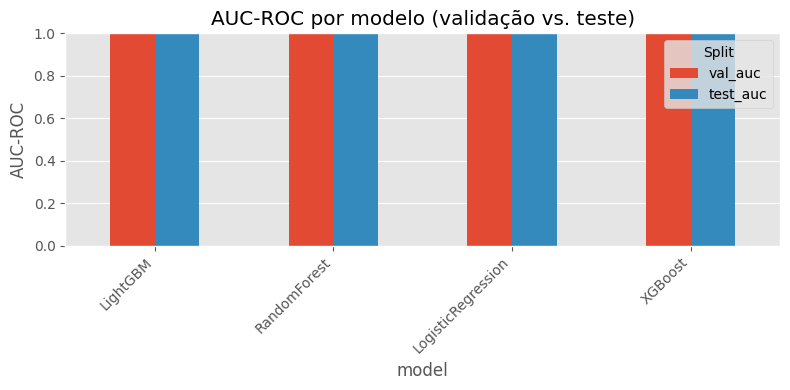

In [11]:
ax = metrics_df.set_index("model")[["val_auc", "test_auc"]].plot.bar(
    figsize=(8, 4), ylim=(0, 1)
)
ax.set_ylabel("AUC-ROC")
ax.set_title("AUC-ROC por modelo (validação vs. teste)")
ax.legend(title="Split")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

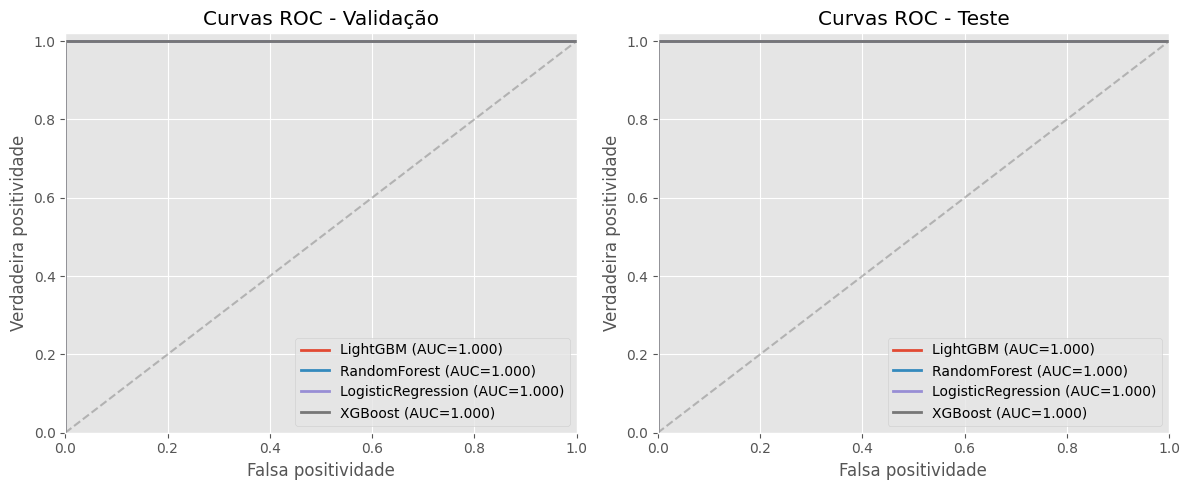

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for res in results:
    fpr_val, tpr_val, _ = roc_curve(y_val, res["val_proba"])
    fpr_test, tpr_test, _ = roc_curve(y_test, res["test_proba"])
    axes[0].plot(
        fpr_val,
        tpr_val,
        lw=2,
        label=f"{res['model']} (AUC={res['val_auc']:.3f})",
    )
    axes[1].plot(
        fpr_test,
        tpr_test,
        lw=2,
        label=f"{res['model']} (AUC={res['test_auc']:.3f})",
    )

for ax, title in zip(axes, ["Validação", "Teste"]):
    ax.plot([0, 1], [0, 1], color="gray", linestyle="--", alpha=0.5)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1.02)
    ax.set_title(f"Curvas ROC - {title}")
    ax.set_xlabel("Falsa positividade")
    ax.set_ylabel("Verdadeira positividade")
    ax.legend()

plt.tight_layout()
plt.show()

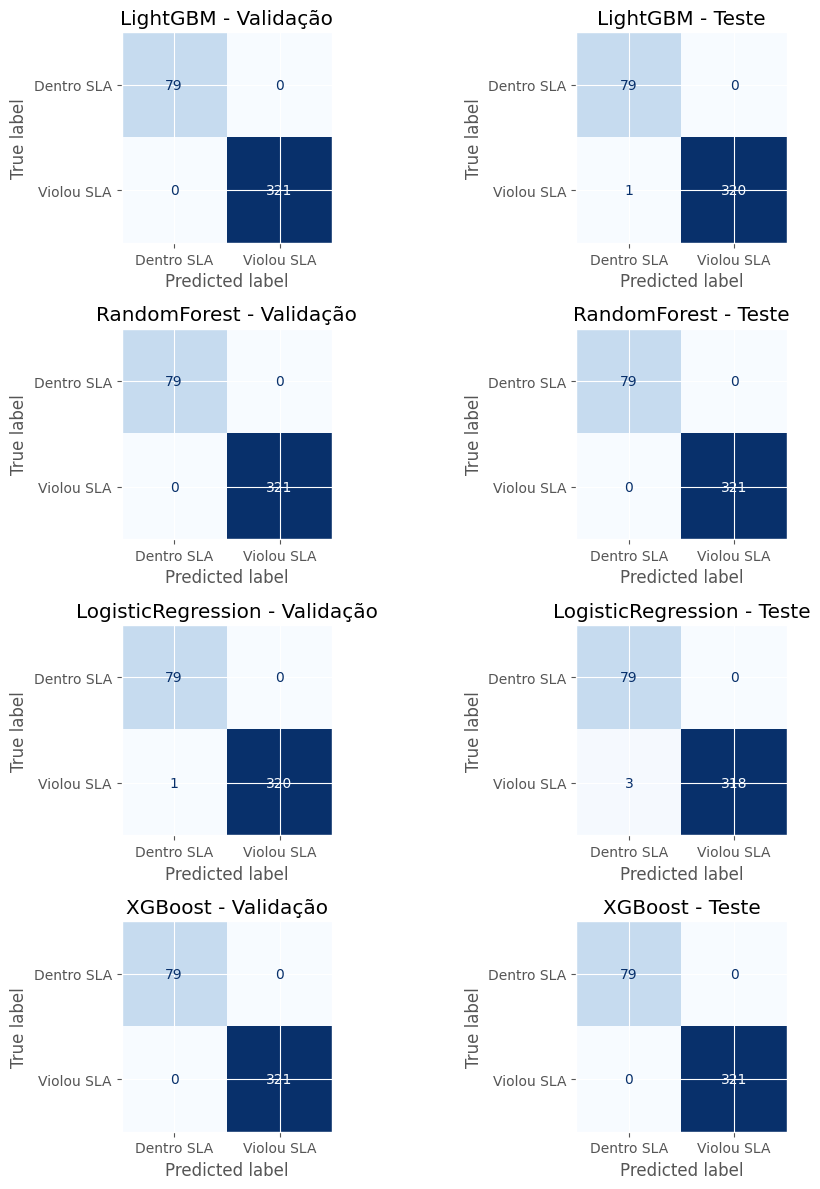

In [13]:
fig, axes = plt.subplots(len(results), 2, figsize=(10, 3 * len(results)))
axes = axes if len(results) > 1 else [axes]
for i, res in enumerate(results):
    row_axes = axes[i]
    for ax, (split_label, cm) in zip(
        row_axes,
        [("Validação", res["val_confusion"]), ("Teste", res["test_confusion"])],
    ):
        disp = ConfusionMatrixDisplay(cm, display_labels=["Dentro SLA", "Violou SLA"])
        disp.plot(ax=ax, colorbar=False, cmap="Blues")
        ax.set_title(f"{res['model']} - {split_label}")

plt.tight_layout()
plt.show()

In [14]:
class_map = {"0": "Dentro do SLA", "1": "Violou SLA"}
report_rows = []
for res in results:
    for split_label, y_true, y_pred in [
        ("Validação", y_val, res["val_pred"]),
        ("Teste", y_test, res["test_pred"]),
    ]:
        report_dict = classification_report(
            y_true, y_pred, output_dict=True, zero_division=0
        )
        for cls in ("0", "1"):
            stats = report_dict[cls]
            report_rows.append(
                {
                    "modelo": res["model"],
                    "split": split_label,
                    "classe": class_map[cls],
                    "precisao": stats["precision"],
                    "recall": stats["recall"],
                    "f1": stats["f1-score"],
                    "suporte": int(stats["support"]),
                }
            )

per_class_reports = pd.DataFrame(report_rows)
per_class_reports

,modelo,split,classe,precisao,recall,f1,suporte
0,LightGBM,Validação,Dentro do SLA,1.0000,1.0000,1.0000,79
1,LightGBM,Validação,Violou SLA,1.0000,1.0000,1.0000,321
2,LightGBM,Teste,Dentro do SLA,0.9875,1.0000,0.9937,79
3,LightGBM,Teste,Violou SLA,1.0000,0.9969,0.9984,321
4,RandomForest,Validação,Dentro do SLA,1.0000,1.0000,1.0000,79
5,RandomForest,Validação,Violou SLA,1.0000,1.0000,1.0000,321
6,RandomForest,Teste,Dentro do SLA,1.0000,1.0000,1.0000,79
7,RandomForest,Teste,Violou SLA,1.0000,1.0000,1.0000,321
8,LogisticRegression,Validação,Dentro do SLA,0.9875,1.0000,0.9937,79
9,LogisticRegression,Validação,Violou SLA,1.0000,0.9969,0.9984,321


In [15]:
reports_text = {
    res["model"]: {"validacao": res["val_report"], "teste": res["test_report"]}
    for res in results
}
reports_text

{'LightGBM': {'validacao': '              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00        79\n           1       1.00      1.00      1.00       321\n\n    accuracy                           1.00       400\n   macro avg       1.00      1.00      1.00       400\nweighted avg       1.00      1.00      1.00       400\n',
  'teste': '              precision    recall  f1-score   support\n\n           0       0.99      1.00      0.99        79\n           1       1.00      1.00      1.00       321\n\n    accuracy                           1.00       400\n   macro avg       0.99      1.00      1.00       400\nweighted avg       1.00      1.00      1.00       400\n'},
 'RandomForest': {'validacao': '              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00        79\n           1       1.00      1.00      1.00       321\n\n    accuracy                           1.00       400\n   macro avg       1.00      